In [1]:
import re    
import molgrid    
import numpy as np    
import torch    
import torch.nn as nn    
import torch.nn.functional as F    
import torch.optim as optim    
from torch.nn import init    
from torch import autograd    
import wandb    
import argparse    
from scipy.stats import pearsonr    
import matplotlib.pyplot as plt    
import matplotlib as mpl
from glob import glob
from argparse import Namespace

In [102]:
batch_size=2
dropout = 0
# Using test because it is a smaller set
ligtr = 'cache/lig_full_bdb.molcache2'
rectr = 'cache/rec_full_bdb.molcache2'
trainfile='tmp/refined.types'
dataroot='/home/anm329/Docking/refined_set_input/'
args = Namespace(dropout=0,hidden_size=0)

In [110]:
train_samples = molgrid.ExampleProvider(ligmolcache=ligtr,recmolcache=rectr,
                                        shuffle=False, duplicate_first=True,
                                        data_root=dataroot,
                                        default_batch_size=batch_size,iteration_scheme=molgrid.IterationScheme.SmallEpoch)
train_samples.populate(trainfile)

In [4]:
gmaker = molgrid.GridMaker()
dims = gmaker.grid_dimensions(14*2)
tensor_shape = (batch_size,) + dims
# model = Net(actual_dims,dropout)
# print(actual_dims,dims)

In [5]:
input_tensor_1 = torch.zeros(dims, dtype=torch.float32)
input_tensor_2 =  torch.zeros(tensor_shape, dtype=torch.float32)
dg1_labels = torch.zeros(batch_size,dtype=torch.float32)

In [6]:
import sys
sys.path.append('/home/anm329/git/models/pytorch/')
from dense_model import Dense as Net

In [7]:
model = Net(dims,args)
pretrained_state_dict = torch.load("gnina_weights/dense_model.pt")
model_dict = model.state_dict()
pretrained_state_dict['fc.weight'] = pretrained_state_dict.pop('affinity_output.weight')
pretrained_state_dict['fc.bias'] = pretrained_state_dict.pop('affinity_output.bias')
pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [129]:
ex = train_samples.next()
lig1_labels = torch.tensor(ex.labels[0]).unsqueeze(0)
center = ex.coord_sets[1].center()
# batch = train_samples.next_batch()
# batch.extract_label(0,dg1_labels)
# lig1_labels = dg1_labels

In [130]:
loss_dict = dict()
t1 = molgrid.Transform()
for val in np.linspace(0,1,num=100):
    t1.set_translation((val,0,0))
    gmaker.forward(ex, t1, input_tensor_1)
    # gmaker.forward(batch, input_tensor_2)
    # fr_complex = input_tensor_1.unsqueeze(0)
    pred_dg = model(input_tensor_1.unsqueeze(0))
    sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')
    loss_dict[val] = sq_e.item()

<ipython-input-130-86db8a653ebb>:9: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')


Text(0, 0.5, 'Squared Error')

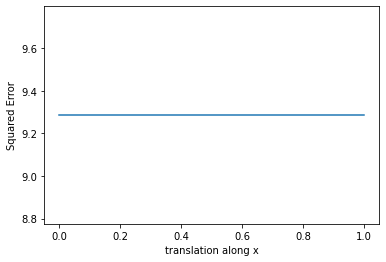

In [131]:
plt.plot(loss_dict.keys(),loss_dict.values())
plt.xlabel('translation along x')
plt.ylabel('Squared Error')

In [94]:
loss_dict = dict()
pred_dict = dict()
t1 = molgrid.Transform()
for val in np.linspace(0,2,num=200):
    t1.set_translation((0,val,0))
    gmaker.forward(ex, t1, input_tensor_1)
    # gmaker.forward(batch, input_tensor_2)
    # fr_complex = input_tensor_1.unsqueeze(0)
    pred_dg = model(input_tensor_1.unsqueeze(0))
    sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')
    loss_dict[val] = sq_e.item()
    pred_dict[val] = pred_dg[0].item()

<ipython-input-94-8435060b0d60>:10: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')


Text(0, 0.5, 'Prediction')

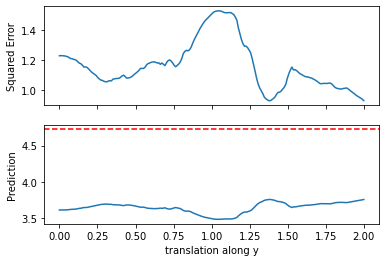

In [101]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(loss_dict.keys(),loss_dict.values())
ax[0].set_ylabel('Squared Error')
ax[1].plot(loss_dict.keys(),pred_dict.values())
ax[1].axhline(lig1_labels[0].item(),c='r',ls='--')
plt.xlabel('translation along y')
plt.ylabel('Prediction')

In [96]:
print(pred_dg[0].item())

3.757629632949829


In [68]:
loss_dict = dict()
t1 = molgrid.Transform()
for val in np.linspace(0,2,num=200):
    t1.set_translation((0,0,val))
    gmaker.forward(ex, t1, input_tensor_1)
    # gmaker.forward(batch, input_tensor_2)
    # fr_complex = input_tensor_1.unsqueeze(0)
    pred_dg = model(input_tensor_1.unsqueeze(0))
    sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')
    loss_dict[val] = sq_e.item()

<ipython-input-68-0b8e494c8202>:9: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')


Text(0, 0.5, 'Squared Error')

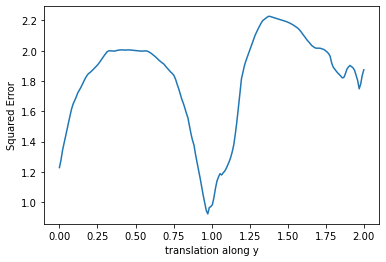

In [69]:
plt.plot(loss_dict.keys(),loss_dict.values())
plt.xlabel('translation along y')
plt.ylabel('Squared Error')

In [88]:
loss_dict = dict()
t1 = molgrid.Transform()
nx = np.linspace(0,1,num=50)
ny = np.linspace(0,1,num=50)
xv, yv = np.meshgrid(nx,ny)
err = np.zeros(xv.shape)
itx = np.nditer(xv,flags=['c_index'])
ity = np.nditer(yv,flags=['c_index'])
for x in itx:
    for y in ity:
        t1.set_translation((float(x),float(y),0))
        gmaker.forward(ex, t1, input_tensor_1)
        # gmaker.forward(batch, input_tensor_2)
        # fr_complex = input_tensor_1.unsqueeze(0)
        pred_dg = model(input_tensor_1.unsqueeze(0))
        sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')
        err[itx.index,ity.index] = sq_e

<ipython-input-88-eb9918d633f5>:16: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sq_e = nn.functional.mse_loss(pred_dg[0],lig1_labels[0],reduction='none')


IndexError: index 50 is out of bounds for axis 1 with size 50

In [84]:
yv.shape

(50, 50)

In [ ]:
plt.plot(loss_dict.keys(),loss_dict.values())
plt.xlabel('translation along y')
plt.ylabel('Squared Error')

In [64]:
rotation_loss = nn.functional.mse_loss(lig1_rep1, lig1_rep2)
rotation_loss += nn.functional.mse_loss(lig2_rep1, lig2_rep2)
rotation_loss += nn.functional.mse_loss(lig3_rep1, lig3_rep2)
loss_lig1 = torch.mean(ind_1 * nn.functional.mse_loss(lig1, lig1_labels, reduction='none'))
loss_lig2 = torch.mean(ind_2 * nn.functional.mse_loss(lig2, lig2_labels, reduction='none'))
loss_lig3 = torch.mean(ind_3 * nn.functional.mse_loss(lig3, lig3_labels, reduction='none'))
ddg1_loss = torch.mean((ind_1 * ind_2) * nn.functional.mse_loss(ddg1, diff1_labels, reduction='none'))
ddg2_loss = torch.mean((ind_2 * ind_3) * nn.functional.mse_loss(ddg2, diff2_labels, reduction='none'))
ddg3_loss = torch.mean((ind_3 * ind_1) * nn.functional.mse_loss(ddg3, diff3_labels, reduction='none'))
cycle_consistency = nn.functional.mse_loss((ddg1-ddg2-ddg3),torch.zeros((batch_size,1)))

In [65]:
print(ind_1)
print(ind_2)
print(ind_3)

tensor([[1.],
        [1.]])
tensor([[1.],
        [1.]])
tensor([[1.],
        [1.]])


In [66]:
loss_lig1

tensor(38.1093, grad_fn=<MeanBackward0>)

In [67]:
loss_lig2

tensor(29.4854, grad_fn=<MeanBackward0>)

In [68]:
loss_lig3

tensor(29.4850, grad_fn=<MeanBackward0>)

In [69]:
print(ddg1_loss)
print(torch.mean((ind_1 * ind_2) * nn.functional.mse_loss(ddg1, diff1_labels,reduction='none')))

tensor(0.5527, grad_fn=<MeanBackward0>)
tensor(0.5527, grad_fn=<MeanBackward0>)


In [70]:
print(ddg2_loss)

tensor(0.0005, grad_fn=<MeanBackward0>)


In [56]:
print(ddg3_loss)

tensor(0., grad_fn=<MeanBackward0>)


In [57]:
cycle_consistency

tensor(4.6467e-09, grad_fn=<MseLossBackward>)

In [61]:
output, lig1, lig2, lig1_rep1, lig2_rep1 = nobias(bw_input_tensor_1[:, 28:, :, :, :], bw_input_tensor_1[:, :28, :, :, :])
_, _, _, lig1_rep2, lig2_rep2 = nobias(bw_input_tensor_2[:, 28:, :, :, :], bw_input_tensor_2[:, :28, :, :, :])
bw_rotation_loss = ddgrotloss1(lig1_rep1, lig1_rep2)    
bw_rotation_loss_1 = ddgrotloss2(lig2_rep1, lig2_rep2)
bw_dg1_loss = DG1criterion(lig1,lig2_label)
bw_dg2_loss = DG2criterion(lig2,lig1_label)
bw_ddg_loss = DDGcriterion(output,-label)
bw_consistency = nn.functional.mse_loss((lig1-lig2),output)

In [47]:
print(ddg_loss,bw_ddg_loss)
print(dg1_loss,bw_dg1_loss)
print(dg2_loss,bw_dg2_loss)
print(consistency,bw_consistency)
print(rotation_loss,bw_rotation_loss)
print(rotation_loss_1,bw_rotation_loss_1)

tensor(0.2443, grad_fn=<MseLossBackward>) tensor(0.2443, grad_fn=<MseLossBackward>)
tensor(40.7172, grad_fn=<MseLossBackward>) tensor(46.2145, grad_fn=<MseLossBackward>)
tensor(46.2145, grad_fn=<MseLossBackward>) tensor(40.7172, grad_fn=<MseLossBackward>)
tensor(1.1511e-09, grad_fn=<MseLossBackward>) tensor(1.1511e-09, grad_fn=<MseLossBackward>)
tensor(1.5187e-07, grad_fn=<MseLossBackward>) tensor(1.4962e-07, grad_fn=<MseLossBackward>)
tensor(1.4962e-07, grad_fn=<MseLossBackward>) tensor(1.5187e-07, grad_fn=<MseLossBackward>)


In [48]:
ddg_loss.backward()
bw_ddg_loss.backward()
# print(input_tensor_1.grad)
# print(bw_input_tensor_1.grad)
non_same = torch.nonzero(~torch.isclose(first_ligand.grad[:,:28,:,:],bw_input_tensor_1.grad[:,28:,:,:],rtol=0,atol=1E-5),as_tuple=True)
print(len(non_same[0]))

0


In [52]:
dg1_loss.backward()
bw_dg1_loss.backward()
# print(input_tensor_1.grad)
# print(bw_input_tensor_1.grad)
non_same = torch.nonzero(~torch.isclose(input_tensor_1.grad[:,:28,:,:],bw_input_tensor_1.grad[:,28:,:,:],rtol=0,atol=1E-5),as_tuple=True)
print(len(non_same[0]))

0


In [53]:
dg2_loss.backward()
bw_dg2_loss.backward()
# print(input_tensor_1.grad)
# print(bw_input_tensor_1.grad)
non_same = torch.nonzero(~torch.isclose(input_tensor_1.grad[:,:28,:,:],bw_input_tensor_1.grad[:,28:,:,:],rtol=0,atol=1E-5),as_tuple=True)
print(len(non_same[0]))

0


In [56]:
consistency.backward()
bw_consistency.backward()
# print(input_tensor_1.grad)
# print(bw_input_tensor_1.grad)
non_same = torch.nonzero(~torch.isclose(input_tensor_1.grad[:,:28,:,:],bw_input_tensor_1.grad[:,28:,:,:],rtol=0,atol=1E-5),as_tuple=True)
print(len(non_same[0]))

0


In [59]:
rotation_loss.backward()
bw_rotation_loss.backward()
# print(input_tensor_1.grad)
# print(bw_input_tensor_1.grad)
non_same = torch.nonzero(~torch.isclose(input_tensor_1.grad[:,:28,:,:],bw_input_tensor_1.grad[:,28:,:,:],rtol=0,atol=1E-5),as_tuple=True)
print(len(non_same[0]))

0


In [62]:
rotation_loss_1.backward()
bw_rotation_loss_1.backward()
# print(input_tensor_1.grad)
# print(bw_input_tensor_1.grad)
non_same = torch.nonzero(~torch.isclose(input_tensor_1.grad[:,:28,:,:],bw_input_tensor_1.grad[:,28:,:,:],rtol=0,atol=1E-5),as_tuple=True)
print(len(non_same[0]))

0


In [ ]:
pub_api = wandb.apis.public.Api()
weight_decay=0
ddg_weight=10
consistency_weight=1
absolute_weight=1
rotation_weight=1
use_weights=None
spec_name=''
rot_warmup=0
state="finished"
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                   filters={"$and":[{"config.use_model":'multtask_latent_nob_def2018'},
                                    {'tags':f'addnl_ligs_1'},
                                    {"config.rot_warmup":rot_warmup},{"config.weight_decay":weight_decay},
                                    {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                    {"config.consistency_loss_weight":consistency_weight},
                                    {"config.absolute_loss_weight":absolute_weight},
                                    {"config.rotation_loss_weight":rotation_weight},
                                    {"config.use_weights":use_weights},{"tags":'combo'},
                                    {"state":state}]})
print(len(runs))